# <center> Post-Processing: Plotting Results

Copyright (C) 2014-2019 The BET Development Team

This notebook demonstrates how to visualize the spaces involved in the stochastic inverse problem.
We leverage some Jupyter `%magics` to load in data files using `%store -r` to recover `bet.sample.discretization` objects from other Example Notebooks.
This notebook makes strong assumptions about directory structure. It may not work if moved.


In [1]:
import bet.postProcess.plotP as plotP
import bet.postProcess.plotDomains as plotD
from IPython.display import Image
import glob

## Create Data

If you have not run a notebook, you can do so directly from the cell below: 

In [2]:
folders = glob.glob('../*')
folders = [f.replace('../','')+'/' for f in folders]
# files irrelevant to examples
folders.remove('matfiles/')
folders.remove('plotting/')
folders.remove('templates/')
folders.remove('parallel_and_serial_sampling/')
# needs work
# folders.remove('sensitivity/') # heatmap and linear
# folders.remove('contaminantTransport/') # contaminent

# to do
folders.remove('nonlinearMap/') # Dirichlet Poisson
folders.remove('nonlinearMap_estimate_error/') # 3D multinomial

# not yet done, unlikely to tackle.
folders.remove('FEniCS/') 
folders.remove('fromFile_ADCIRCMap/') 

print('Pick an Example')
for idx, f in enumerate(folders):
    print('%2d. %s'%(idx,f[:-1] ))

Pick an Example
 0. contaminantTransport
 1. validationExample
 2. sensitivity
 3. linearMap


In [3]:
############ MAKE SELECTION ############
user_selection = 0
########################################

folder = '../'+folders[user_selection]
notebook_files = glob.glob('%s/*.ipynb'%folder)
print("You have selected %s. The files inside are:\n"%folder, *notebook_files)

You have selected ../contaminantTransport/. The files inside are:
 ../contaminantTransport/contaminant.ipynb


In [4]:
for notebook in notebook_files:
    example_filename = notebook[:-6] # strip file-ending
    !jupyter nbconvert --ExecutePreprocessor.timeout=-1 --to notebook --execute $example_filename'.ipynb'
    !rm $example_filename'.nbconvert.ipynb'
print("Finished running file and cleaning up.")

[NbConvertApp] Converting notebook ../contaminantTransport/contaminant.ipynb to notebook
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 888503 bytes to ../contaminantTransport/contaminant.nbconvert.ipynb
Finished running file and cleaning up.


# Load Data

In [5]:
%store -r my_discretization

In [6]:
input_samples = my_discretization.get_input_sample_set()
output_samples = my_discretization.get_output_sample_set()
dim_input, dim_output = input_samples.get_dim(), output_samples.get_dim()

In [7]:
print('This example maps a ' + str(dim_input) + \
' dimensional space to a ' + str(dim_output) + \
' dimensional space. ' + '\nImages will be saved to: %s'%folder)

This example maps a 5 dimensional space to a 4 dimensional space. 
Images will be saved to: ../contaminantTransport/


## Suggested Changes
The example notebooks have been formatted to store data at the end of their runs in the local Jupyter namespace but delete all associated data files. If you want to load this data with `np.load`, you are welcome to comment out the last cell in the example files and load the data from `.mat` files. 

At this point, the only thing that should change in the plotP.* inputs
should be either the nbins values or sigma (which influences the kernel
density estimation with smaller values implying a density estimate that
looks more like a histogram and larger values smoothing out the values
more).

There are ways to determine "optimal" smoothing parameters (e.g., see CV, GCV,
and other similar methods), but we have not incorporated these into the code
as lower-dimensional marginal plots generally have limited value in understanding
the structure of a high dimensional non-parametric probability measure.

## 2D Plots

## Input Space

In [8]:
input_bins_per_dim = [10 for _ in range(dim_input)]
marker_size = 50
if dim_input==2:
    # Show some plots of the different sample sets
    plotD.scatter_2D_input(my_discretization, markersize = marker_size,
                    filename = '%sParameter_Samples'%folder,
                    file_extension = '.png')

else:
    print("Higher than 2D detected. Using `multi` mode.")
    %store -r param_ref
    plotD.scatter_2D_multi(input_samples, ref_sample=param_ref, showdim = 'all',
                    filename = 'Parameter_Samples', img_folder=folder,
                    markersize = marker_size, file_extension = '.png')
    

print("Input space plotting completed. You can now view your images.")

Higher than 2D detected. Using `multi` mode.
Input space plotting completed. You can now view your images.


### Parameter Samples

../contaminantTransport/Parameter_Samples_d2_d5.png


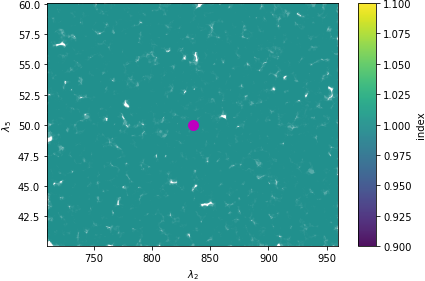

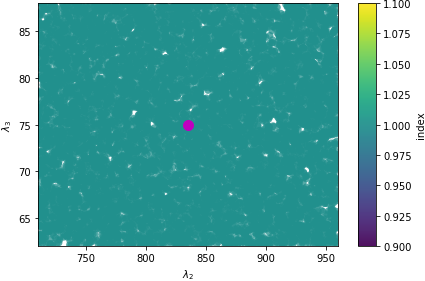

../contaminantTransport/Parameter_Samples_d2_d3.png
../contaminantTransport/Parameter_Samples_d1_d3.png


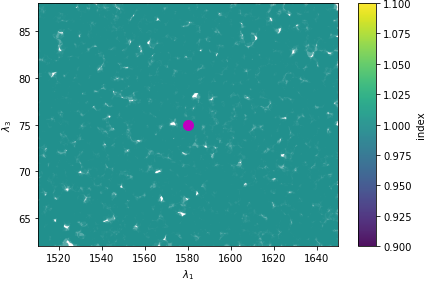

../contaminantTransport/Parameter_Samples_d1_d4.png


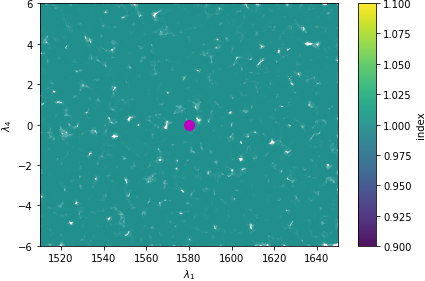

../contaminantTransport/Parameter_Samples_d3_d4.png


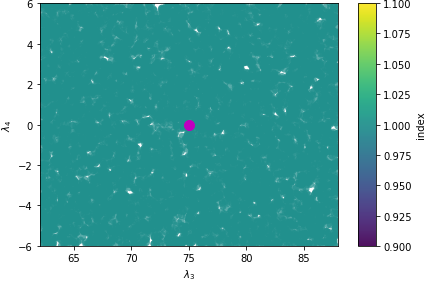

../contaminantTransport/Parameter_Samples_d2_d4.png


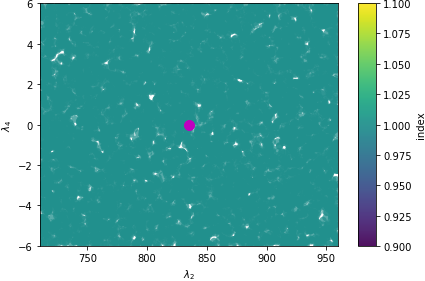

../contaminantTransport/Parameter_Samples_d4_d5.png


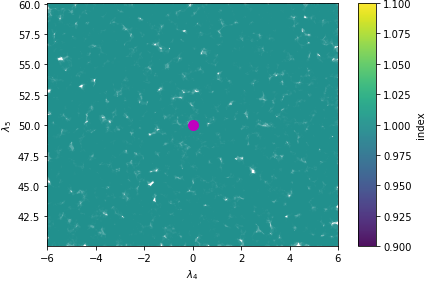

../contaminantTransport/Parameter_Samples_d1_d5.png


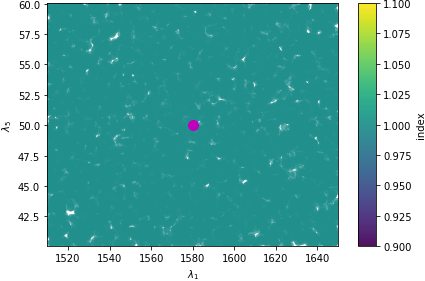

../contaminantTransport/Parameter_Samples_d3_d5.png


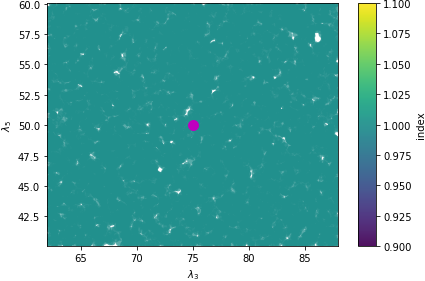

../contaminantTransport/Parameter_Samples_d1_d2.png


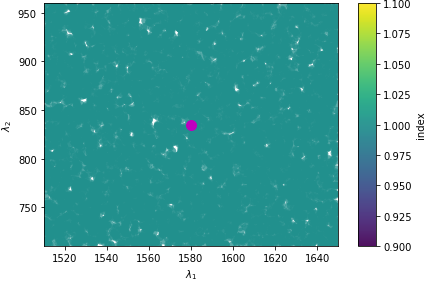

In [9]:
# display(Image('%sParameter_Samples.png'%folder))
for f in glob.glob('%sParameter_Samples*.png'%(folder)):
        print(f)
        display(Image(f))
        

## Output Samples

In [10]:
output_bins_per_dim = [10 for _ in range(output_samples.get_dim())]
marker_size = 25
if dim_output==2:
    plotD.scatter_2D_output(my_discretization, markersize=marker_size,
                    filename = '%sQoI_Samples'%(folder),
                    file_extension = '.png')
    # plot observed distribution discretization
    plotD.scatter_2D(my_discretization._output_probability_set, markersize=marker_size*10,
                    filename = '%sData_Space_Discretization'%(folder),
                    file_extension = '.png')

else:
    %store -r Q_ref
    print("Higher than 2D detected. Using `multi` mode.")
    plotD.scatter_2D_multi(output_samples, ref_sample=Q_ref, showdim = 'all',
                    filename = 'QoI_Samples', img_folder=folder,
                    file_extension = '.png')
    
    plotD.scatter_2D_multi(my_discretization._output_probability_set, 
                    ref_sample=Q_ref, showdim = 'all', markersize=marker_size*10,
                    filename = 'Data_Space_Discretization', img_folder=folder,
                    file_extension = '.png')
    
    plotD.show_data_domain_multi(my_discretization, Q_ref=Q_ref, showdim = 'all',
                    img_folder=folder, file_extension='.png')

print("Output space plotting completed. You can now view your images.")

Higher than 2D detected. Using `multi` mode.


/home/mpilosov/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'triangles'
  s)


Output space plotting completed. You can now view your images.


### QoI Samples

../contaminantTransport/QoI_Samples_d2_d3.png


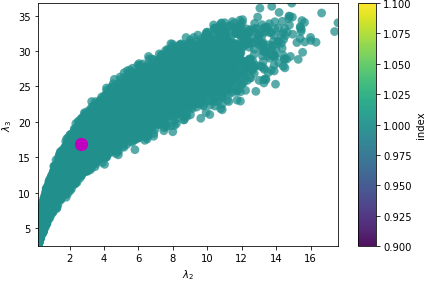

../contaminantTransport/QoI_Samples_d2_d4.png


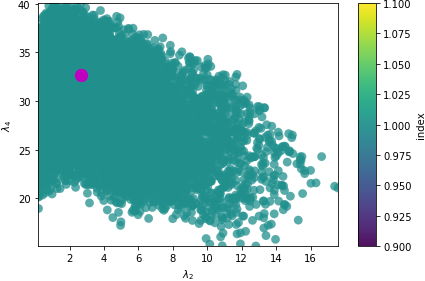

../contaminantTransport/QoI_Samples_d1_d3.png


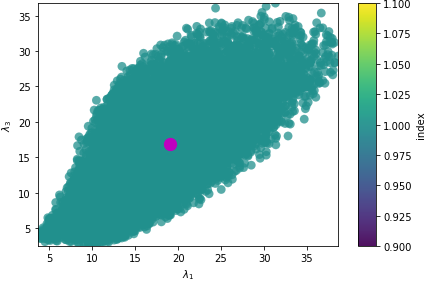

../contaminantTransport/QoI_Samples_d1_d2.png


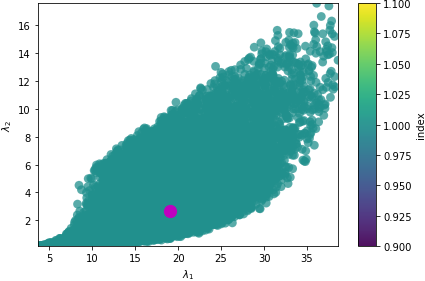

../contaminantTransport/QoI_Samples_d3_d4.png


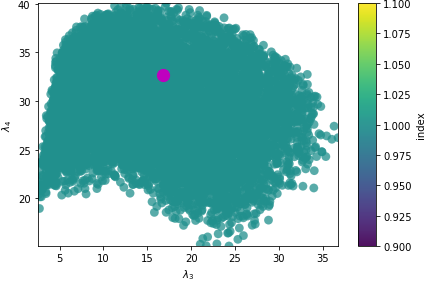

../contaminantTransport/QoI_Samples_d1_d4.png


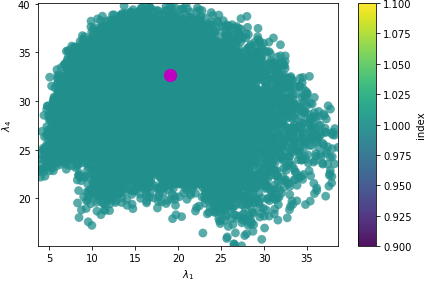

In [11]:
for f in glob.glob('%s/QoI_Samples*.png'%(folder)):
    print(f)
    display(Image(f))

../contaminantTransport/q1_q2_domain_Q_cs.png


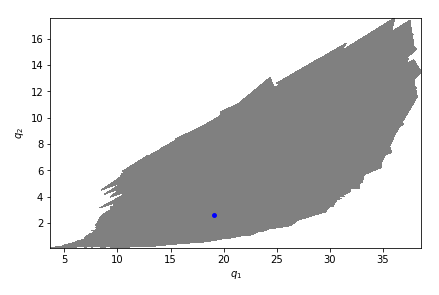

../contaminantTransport/q3_q4_domain_Q_cs.png


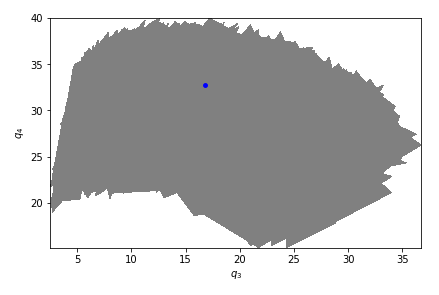

../contaminantTransport/q1_q3_domain_Q_cs.png


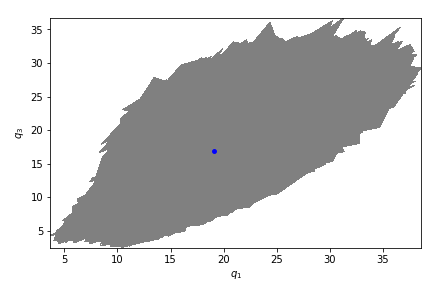

../contaminantTransport/q2_q4_domain_Q_cs.png


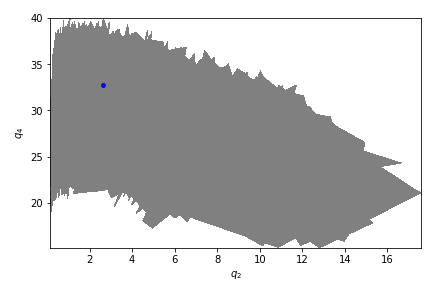

../contaminantTransport/q2_q3_domain_Q_cs.png


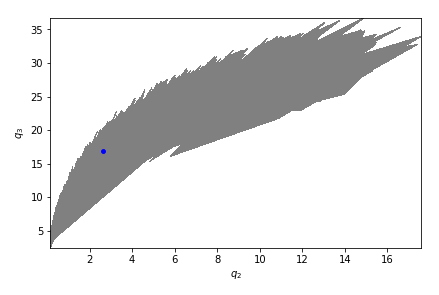

../contaminantTransport/q1_q4_domain_Q_cs.png


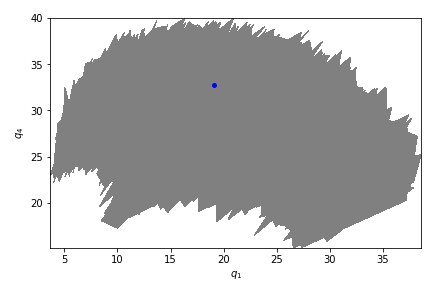

In [12]:
# for multi-plots
for f in glob.glob('%s/q*domain*.png'%(folder)):
    print(f)
    display(Image(f))
    
## plot without reference data parameter:
# for f in glob.glob('%s/domain*.png'%(folder)):
#         print(f)
#         display(Image(f))

## Data Space

../contaminantTransport/Data_Space_Discretization_d1_d2.png


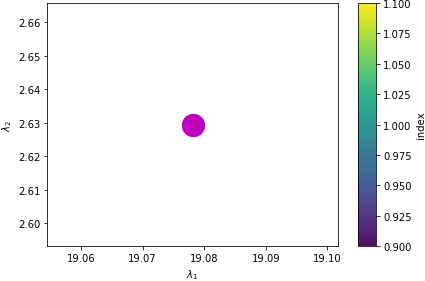

../contaminantTransport/Data_Space_Discretization_d2_d4.png


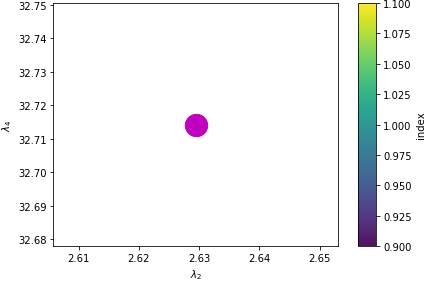

../contaminantTransport/Data_Space_Discretization_d2_d3.png


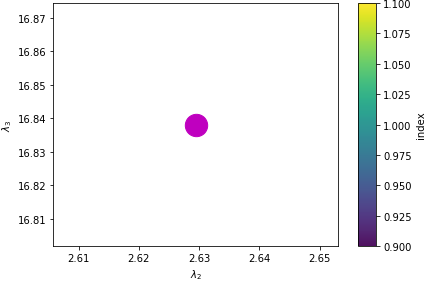

../contaminantTransport/Data_Space_Discretization_d1_d4.png


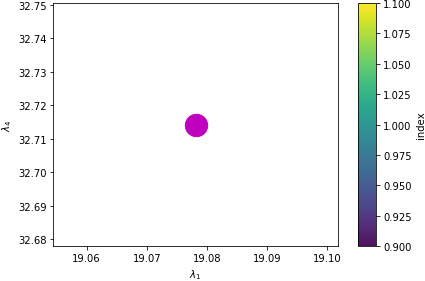

../contaminantTransport/Data_Space_Discretization_d3_d4.png


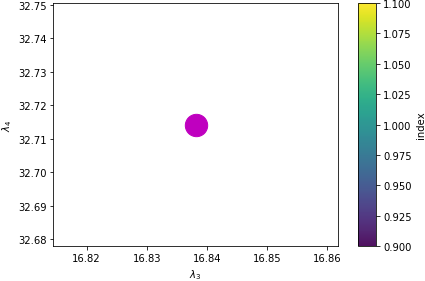

../contaminantTransport/Data_Space_Discretization_d1_d3.png


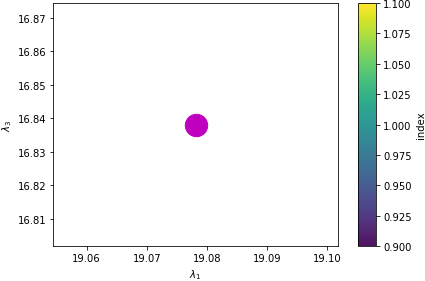

In [13]:
for f in glob.glob('%sData_Space_Discretization*'%(folder)):
    print(f)
    display(Image(f))

# Solution to Stochastic Inverse Problem
(Try changing `sigma`, the smoothing parameter)

In [14]:
sigma = 1
input_bins_per_dim = [10 for _ in range(dim_input)]
if dim_input > 1:
    # calculate 2d marginal probs
    (bins, marginals2D) = plotP.calculate_2D_marginal_probs(input_samples,
                    nbins = input_bins_per_dim)

    # plot 2d marginals probs
    plotP.plot_2D_marginal_probs(marginals2D, bins, input_samples, 
                    filename = '%s%s_raw'%(folder, folder[3:-1]),
                    file_extension = '.png', plot_surface=False)

    # smooth 2d marginals probs (optional)
    marginals2D = plotP.smooth_marginals_2D(marginals2D, bins, sigma=sigma)

    # plot 2d marginals probs
    plotP.plot_2D_marginal_probs(marginals2D, bins, input_samples, 
                    filename = '%s%s_smooth'%(folder, folder[3:-1]), lam_ref = param_ref,
                    file_extension = '.png', plot_surface=False)

/home/mpilosov/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


## Raw 2D Marginals

../contaminantTransport/contaminantTransport_raw_2D_0_3.png


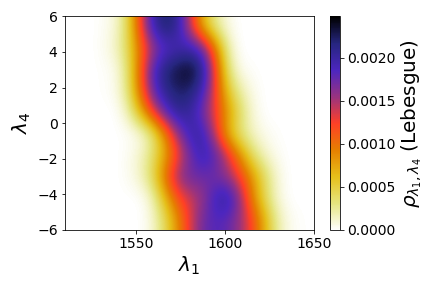

../contaminantTransport/contaminantTransport_raw_2D_3_4.png


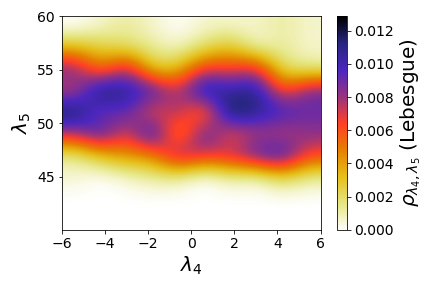

../contaminantTransport/contaminantTransport_raw_2D_1_3.png


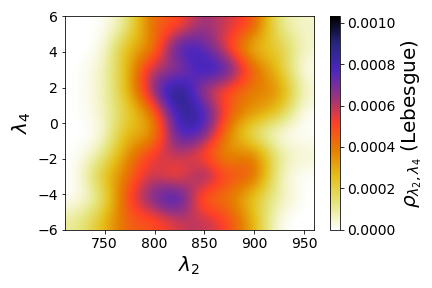

../contaminantTransport/contaminantTransport_raw_2D_1_2.png


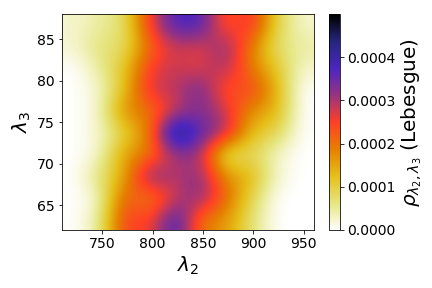

../contaminantTransport/contaminantTransport_raw_2D_0_4.png


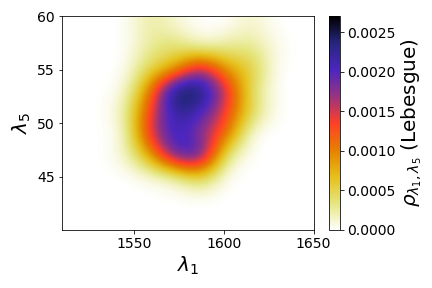

../contaminantTransport/contaminantTransport_raw_2D_2_4.png


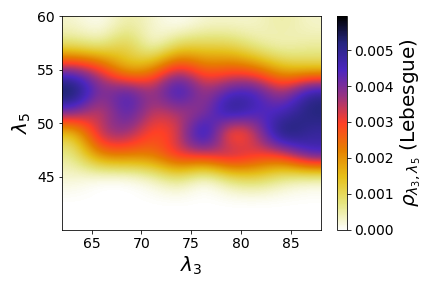

../contaminantTransport/contaminantTransport_raw_2D_0_1.png


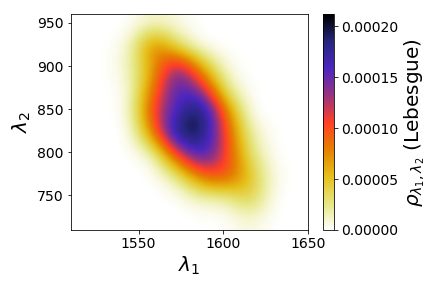

../contaminantTransport/contaminantTransport_raw_2D_1_4.png


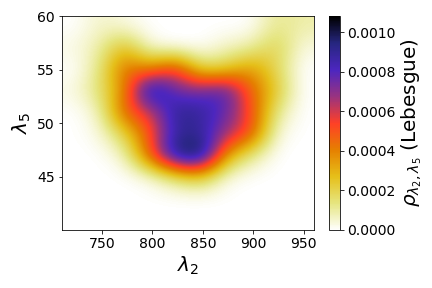

../contaminantTransport/contaminantTransport_raw_2D_0_2.png


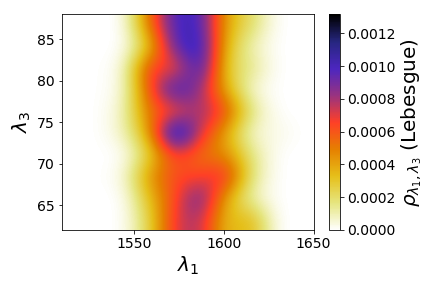

../contaminantTransport/contaminantTransport_raw_2D_2_3.png


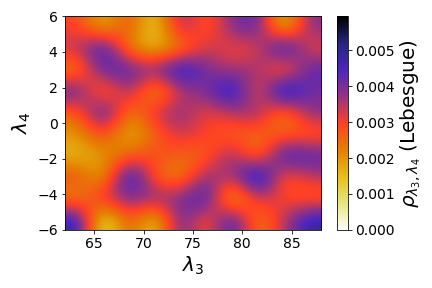

In [15]:
for f in glob.glob('%s*raw*2D*'%(folder)):
    print(f)
    display(Image(f))

## Smoothed 2D Marginals

../contaminantTransport/contaminantTransport_smooth_2D_1_3.png


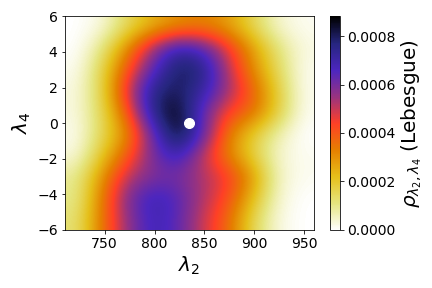

../contaminantTransport/contaminantTransport_smooth_2D_1_4.png


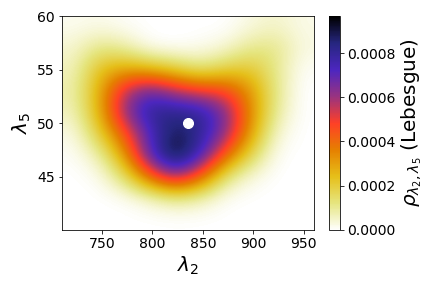

../contaminantTransport/contaminantTransport_smooth_2D_0_4.png


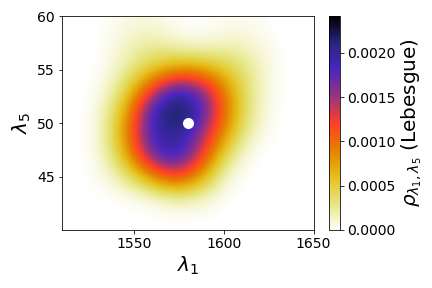

../contaminantTransport/contaminantTransport_smooth_2D_3_4.png


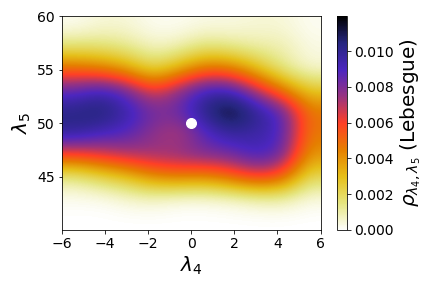

../contaminantTransport/contaminantTransport_smooth_2D_2_3.png


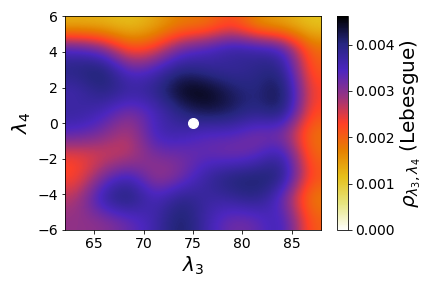

../contaminantTransport/contaminantTransport_smooth_2D_0_2.png


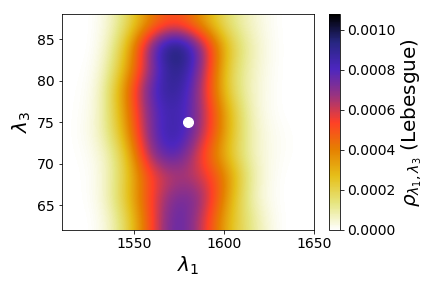

../contaminantTransport/contaminantTransport_smooth_2D_1_2.png


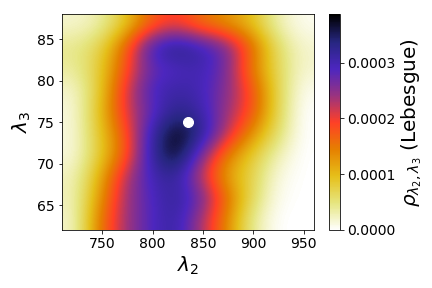

../contaminantTransport/contaminantTransport_smooth_2D_2_4.png


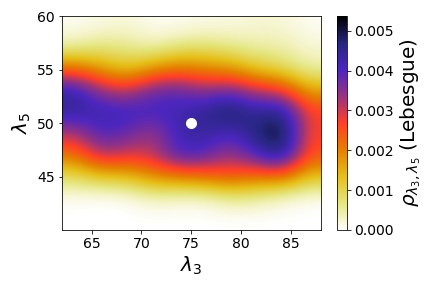

../contaminantTransport/contaminantTransport_smooth_2D_0_1.png


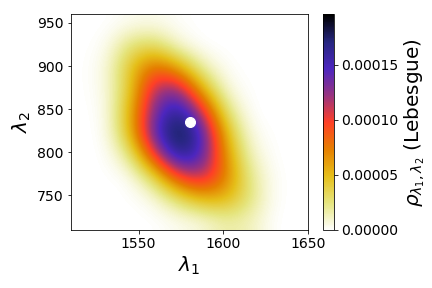

../contaminantTransport/contaminantTransport_smooth_2D_0_3.png


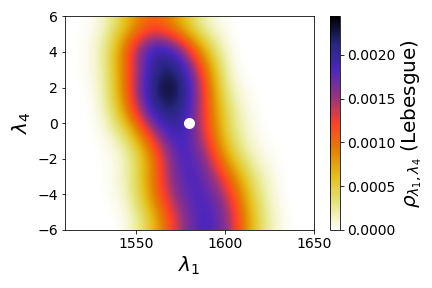

In [16]:
for f in glob.glob('%s*smooth*2D*'%(folder)):
    print(f)
    display(Image(f))

## 1D Plots

In [17]:
# calculate 1d marginal probs
(bins, marginals1D) = plotP.calculate_1D_marginal_probs(input_samples,
                                                        nbins = input_bins_per_dim)

# plot 1d marginal probs
plotP.plot_1D_marginal_probs(marginals1D, bins, input_samples,
                             filename = '%s%s_raw'%(folder, folder[3:-1]),
                             file_extension = '.png')

# smooth 1d marginal probs (optional)
marginals1D = plotP.smooth_marginals_1D(marginals1D, bins, sigma=sigma)

# plot 2d marginal probs
plotP.plot_1D_marginal_probs(marginals1D, bins, input_samples,
                             filename = '%s%s_smooth'%(folder, folder[3:-1]), lam_ref = param_ref,
                             file_extension = '.png')


<Figure size 432x288 with 0 Axes>

## Raw 1D Marginals

../contaminantTransport/contaminantTransport_raw_1D_2.png


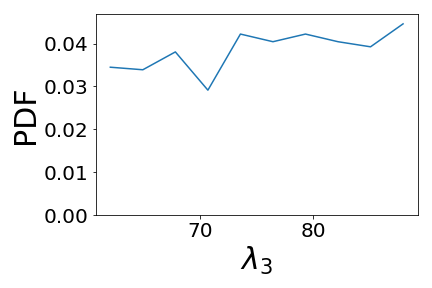

../contaminantTransport/contaminantTransport_raw_1D_3.png


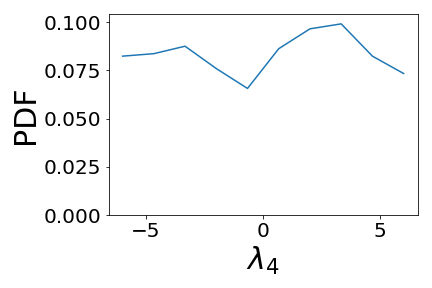

../contaminantTransport/contaminantTransport_raw_1D_4.png


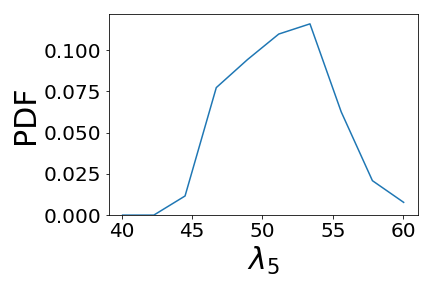

../contaminantTransport/contaminantTransport_raw_1D_0.png


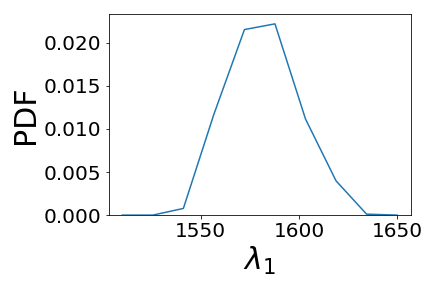

../contaminantTransport/contaminantTransport_raw_1D_1.png


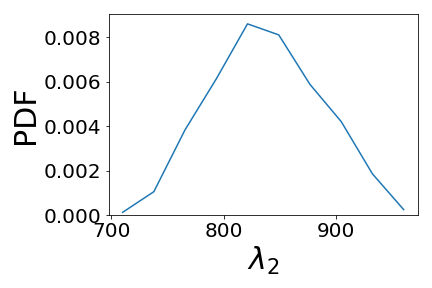

In [18]:
for f in glob.glob('%s%s_raw_1D*'%(folder, folder[3:-1])):
    print(f)
    display(Image(f))

## Smoothed 1D Marginals

../contaminantTransport/contaminantTransport_smooth_1D_2.png


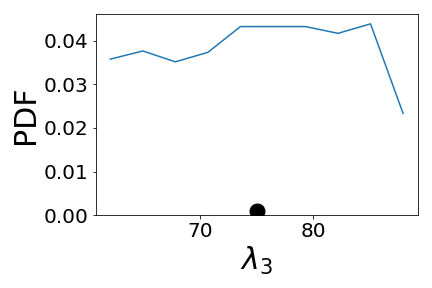

../contaminantTransport/contaminantTransport_smooth_1D_1.png


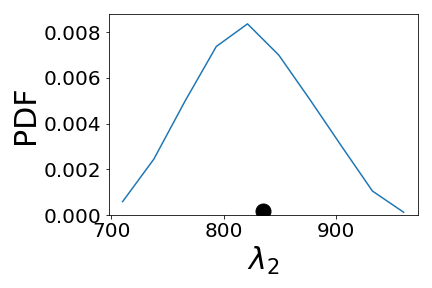

../contaminantTransport/contaminantTransport_smooth_1D_0.png


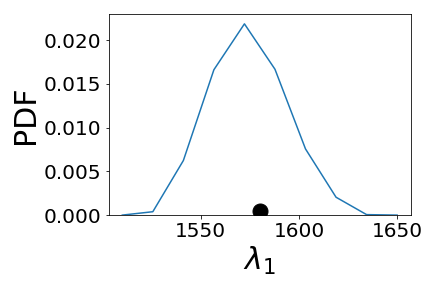

../contaminantTransport/contaminantTransport_smooth_1D_4.png


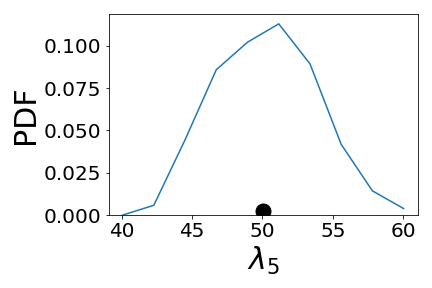

../contaminantTransport/contaminantTransport_smooth_1D_3.png


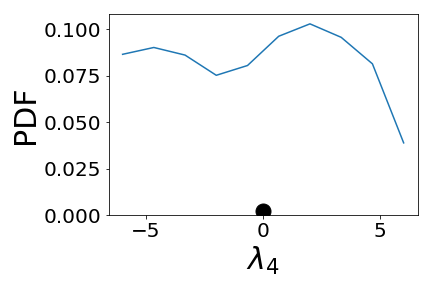

In [19]:
for f in glob.glob('%s%s_smooth_1D*'%(folder, folder[3:-1])):
    print(f)
    display(Image(f))

# Remove all Files (optional)

In [20]:
!rm $folder*.png